In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from CustomRNN import PrunedDeepRNN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [6]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
BATCH_SIZE = 16
EPOCHS = 12
OUTPUT_SIZE = 2
INPUT_SIZE = 128

#### Customize `Dataset` and create loaders

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

Create train loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

Create test loader

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Some helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor)

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Define model class

In [0]:
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers : list):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_layers[0])
        self.rnn = PrunedDeepRNN(hidden_layers[0], hidden_layers, mode='tanh')
        self.fc = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)

        output, hiddens = self.rnn(embedded)

        output = self.fc(output[-1])
        return output, hiddens

#### Training function

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output, hiddens = classifier(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        classifier.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('{}/{}\tLoss: {:.5f}'.format(i * len(string), len(train_loader.dataset), total_loss / i * len(string)))
    return hiddens

#### Testing function

In [0]:
test_acc = []

In [0]:
def test(string=None):
    if string:
        input, seq_lens, target = make_variables([string], [])

        output, _ = classifier(input)

        pred = output.data.max(1, keepdim=True)[1]
        print('{} is {}'.format(string, pred))
        return
    
    print('\nEvaluating model...')
    correct = 0
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output, _ = classifier(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct.item() / test_data_size
    test_acc.append(acc)
        
    print('Test set accuracy: {}/{} ({:.2f}%)\n'.format(correct, test_data_size, acc))

#### Time for action!

#### Base RNN

In [0]:
classifier = RNNModel(INPUT_SIZE, 2, [100, 100, 100])

In [0]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [0]:
h2h = {'1': [], '2': [], '3': []}

In [22]:
%%time
for epoch in range(1, EPOCHS+1):
    print('Epoch #{}\n{}'.format(epoch, 12*'-'))
    hiddens = train()
    h2h['1'].append(hiddens[0][0].tolist()[-1])
    h2h['2'].append(hiddens[1][0].tolist()[-1])
    h2h['3'].append(hiddens[2][0].tolist()[-1])
    test()

Epoch #1
------------
1600/18750	Loss: 9.87580
3200/18750	Loss: 9.80871
4800/18750	Loss: 9.48729
6400/18750	Loss: 9.66168
8000/18750	Loss: 9.77871
9600/18750	Loss: 9.88748
11200/18750	Loss: 9.85129
12800/18750	Loss: 9.78640
14400/18750	Loss: 9.48220
16000/18750	Loss: 9.07506
17600/18750	Loss: 8.95864

Evaluating model...
Test set accuracy: 5337/6250 (85.39%)

Epoch #2
------------
1600/18750	Loss: 5.26538
3200/18750	Loss: 5.24429
4800/18750	Loss: 5.23015
6400/18750	Loss: 5.13525
8000/18750	Loss: 5.10571
9600/18750	Loss: 5.62323
11200/18750	Loss: 6.17090
12800/18750	Loss: 6.54759
14400/18750	Loss: 6.78931
16000/18750	Loss: 7.00573
17600/18750	Loss: 7.15862

Evaluating model...
Test set accuracy: 4609/6250 (73.74%)

Epoch #3
------------
1600/18750	Loss: 8.79822
3200/18750	Loss: 8.41514
4800/18750	Loss: 8.30808
6400/18750	Loss: 8.24005
8000/18750	Loss: 8.41413
9600/18750	Loss: 8.45085
11200/18750	Loss: 8.42422
12800/18750	Loss: 8.40989
14400/18750	Loss: 8.33549
16000/18750	Loss: 8.23988


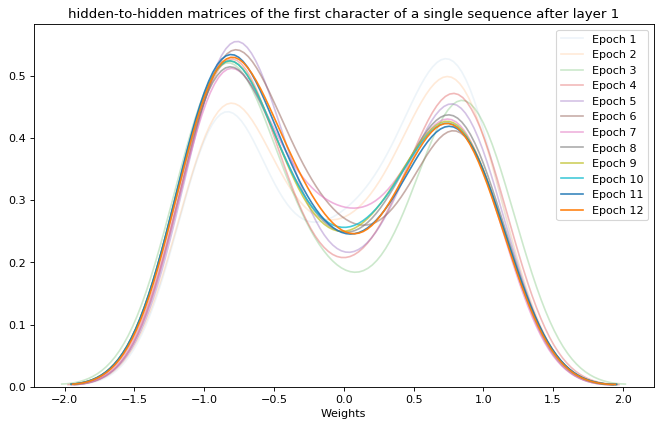

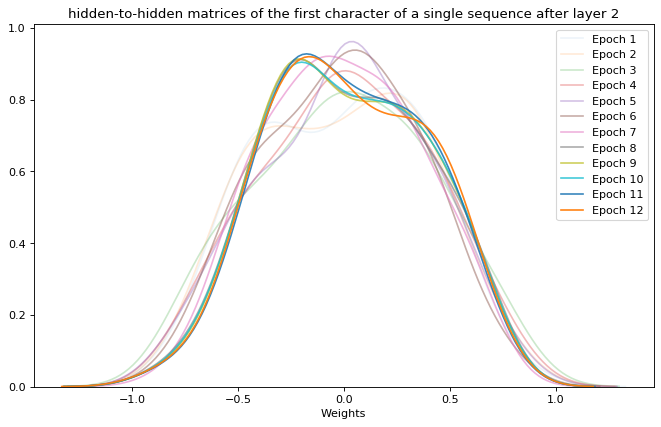

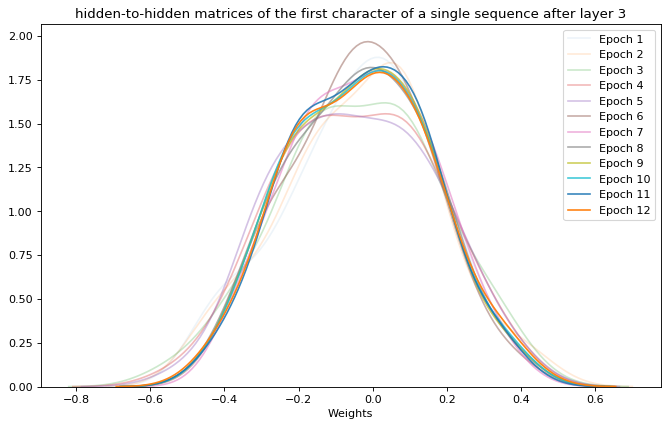

In [23]:
for l in h2h:
    plt.figure(figsize=(10, 6), dpi= 80)
    plt.xlabel('Weights')
    plt.title('hidden-to-hidden matrices of the first character of a single sequence after layer {}'.format(l))
    for i in range(1, EPOCHS+1):
        sns.kdeplot(h2h[l][i-1], shade=False, alpha=0.08*i, label='Epoch {}'.format(i))
    plt.show()